In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wrds

db = wrds.Connection(wrds='tuomas_pkknn')

Enter your WRDS username [tuomasp]:tuomas_pkknn
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [2]:
import statsmodels.api as sm

In [3]:
ret_mkt = db.raw_sql("select date,vwretd "
           "from crsp.msi "
           "where date>='1928-01-01' "
           "and date<='2004-12-31'",
           date_cols=["date"])

In [5]:
ret_stocks = db.raw_sql("select a.permno, a.date, b.shrcd, b.exchcd, a.ret, a.shrout, a.prc "
                        "from crsp.msf as a left join crsp.msenames as b on a.permno=b.permno "
                        "and b.namedt<=a.date and a.date<=b.nameendt "
                        "where a.date between '01/01/1928' and '12/31/2004' "
                        "and b.exchcd between 1 and 2 and b.shrcd between 10 and 11",
                        date_cols=["date"])

In [4]:
ret_rf = db.raw_sql("select mcaldt, tmytm from crsp.tfz_mth_rf " 
                    "where kytreasnox=2000001 and mcaldt>='1928-01-01' and mcaldt<='2004-12-31'")

In [101]:
# (a)

# we get the t-bill returns
ret_rf["tret"] = np.exp(ret_rf["tmytm"]/1200)-1
ret_rf["date"] = pd.to_datetime(ret_rf["mcaldt"])

ret_mkt["date"] = pd.to_datetime(ret_mkt["date"])
ret_stocks["date"] = pd.to_datetime(ret_stocks["date"])

ret_mr = pd.merge(ret_rf, ret_mkt, on = 'date')
ret_mr["riskp"] = ret_mr["vwretd"] - ret_mr["tret"]

var_mkt = ret_mkt["vwretd"].var()

df_ret = pd.merge(ret_mr, ret_stocks, on='date')

In [102]:
df_regr = df_ret.groupby("permno").apply(lambda row: sm.OLS(row["ret"] - row["tret"], sm.add_constant(row["riskp"])).fit().params)
df_regr = df_regr.unstack(level=-1)
df_regr.columns = ["alpha", "beta"]

<AxesSubplot:ylabel='Frequency'>

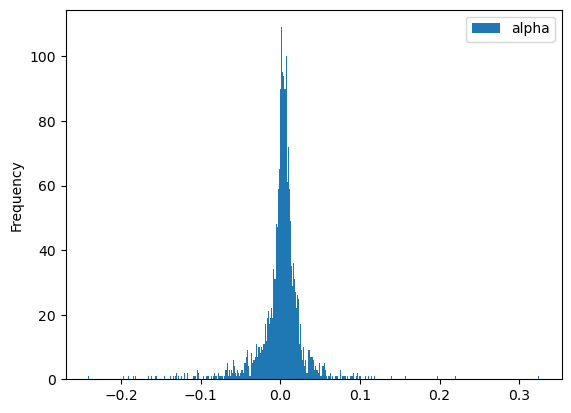

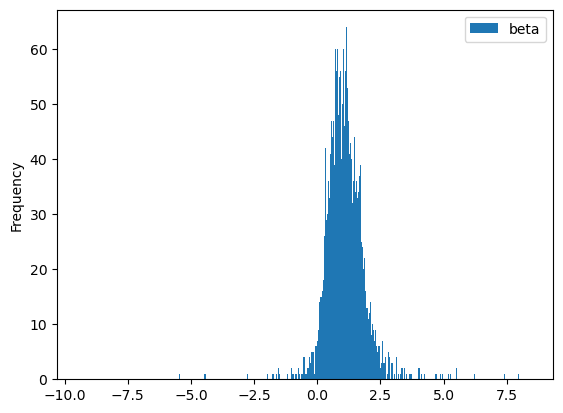

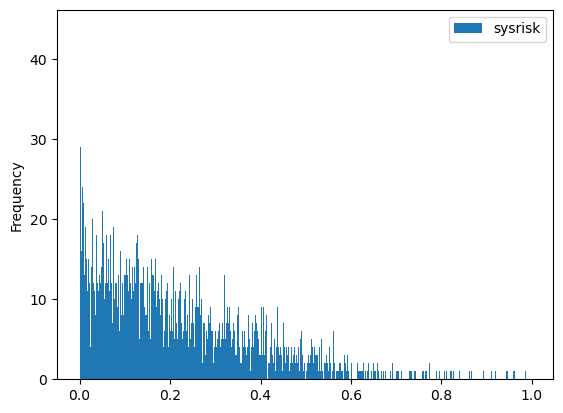

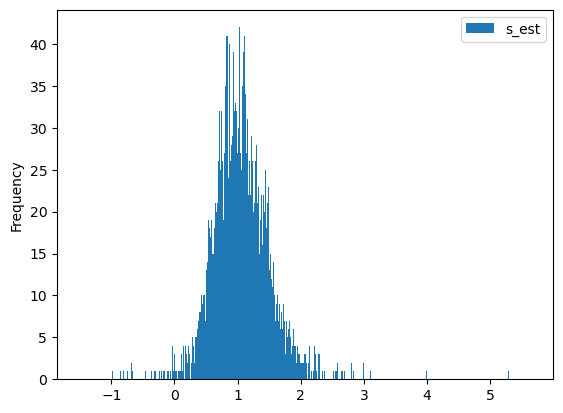

In [105]:
df_all = pd.merge(df_ret, df_regr["beta"], how='left', on='permno')

df_regr[["alpha"]].plot.hist(bins=500)
df_regr[["beta"]].plot.hist(bins=500)

betas = df_all.groupby("permno").mean()["beta"]
ret_vars = df_all.groupby("permno").var()["ret"]
df_sysrisk = pd.merge(betas, ret_vars, on="permno")
df_sysrisk["sysrisk"] = df_sysrisk["beta"]**2 * var_mkt/df_sysrisk["ret"]
df_sysrisk = df_sysrisk[df_sysrisk["sysrisk"] <= 1]
df_sysrisk[["sysrisk"]].plot.hist(bins=500)
# we drop the values above 1 to have a relevant graph, the values above 1 may be due to measurement errors or other issues with the data as there are only a few of them

df_sysrisk["s_est"] = 2/3 * df_sysrisk["beta"] + 1/3
df_sysrisk[["s_est"]].plot.hist(bins=500)

### Exercise 2 a)
As we can see on the graphs above, the alphas are centered in 0 with not much variance as we could expect according to the theory.

The betas experience more variance, even though most of them seem to be between 0 and 2, centered around 1 (which once again seems relevant, as most of stocks follow at least the general pattern of the market). There are quite a few extreme values though.

The systematic risks are distributed over a larger interval: apart from a few stocks above 50%, most of the stocks have the fraction of their systematic risk which is between 0 and 50%, showing that in a large majority of cases, most of the risk of a stock is composed by idiosyncratic risk.

The shrinkage estimators have obviously the same shape than the betas, but with way less variance and still centered around 1.

/tmp/ipykernel_10109/1760576522.py:9: RuntimeWarning: invalid value encountered in double_scalars
  vw_ret = df_all.groupby(["date", "dec"]).apply(lambda row: ((row["ret"] - row["tret"]) * row["lagged"]).sum()/row["lagged"].sum()).to_frame().fillna(0.0)


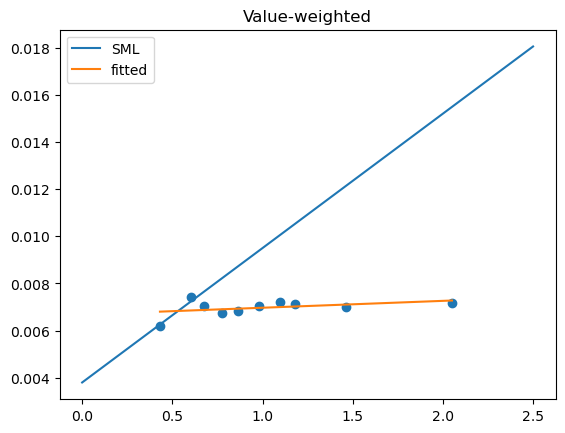

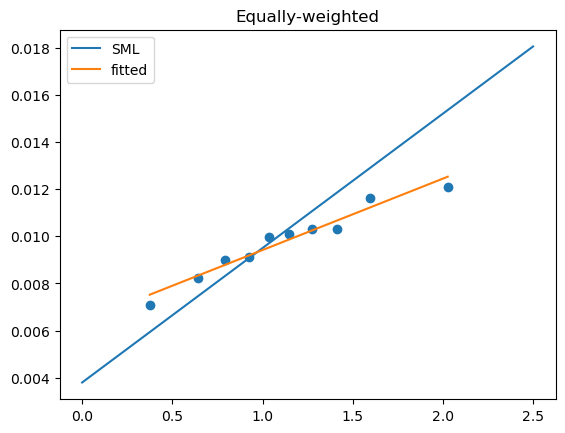

In [119]:
# (b)

# the absolute value is used due to a notation by WRDS which puts '-' signs in front of prices
df_all["mc"] = df_all["shrout"] * np.abs(df_all["prc"])
df_all["lagged"] = df_all.groupby("permno")["mc"].shift(1).to_frame()
# +1 to get deciles 1-10 and not 0-9
df_all["dec"] = df_all[["beta", "date"]].groupby("date").transform(lambda q: pd.qcut(q, 10, labels=False)) + 1

vw_ret = df_all.groupby(["date", "dec"]).apply(lambda row: ((row["ret"] - row["tret"]) * row["lagged"]).sum()/row["lagged"].sum()).to_frame().fillna(0.0)
mean_ret = vw_ret.groupby("dec").mean()
vw_betas = df_all.groupby("dec").apply(lambda row: (row["beta"] * row["lagged"]).sum()/row["lagged"].sum()).to_frame()

x_axis = np.linspace(0, 2.5, 10)
sml = df_all["tret"].mean() + df_all["riskp"].mean() * x_axis

intercept_vw, slope_vw = sm.OLS(mean_ret, sm.add_constant(vw_betas)).fit().params
fitted_vw = intercept_vw + slope_vw * vw_betas

plt.plot(x_axis, sml, label="SML")
plt.plot(vw_betas, fitted_vw, label="fitted")
plt.scatter(vw_betas, mean_ret)
plt.title("Value-weighted")
plt.legend()
plt.show()

ew_ret = df_all.groupby(["date", "dec"]).apply(lambda row: (row["ret"] - row["tret"]).sum()/len(row)).to_frame().fillna(0.0)
ew_mean_ret = ew_ret.groupby("dec").mean()
ew_betas = df_all.groupby("dec").apply(lambda row: row["beta"].sum()/len(row)).to_frame()

intercept_ew, slope_ew = sm.OLS(ew_mean_ret, sm.add_constant(ew_betas)).fit().params
fitted_ew = intercept_ew + slope_ew * ew_betas

plt.plot(x_axis, sml, label="SML")
plt.plot(ew_betas, fitted_ew, label="fitted")
plt.scatter(ew_betas, ew_mean_ret)
plt.title("Equally-weighted")
plt.legend()
plt.show()

### Exercise 2b)
We are sorting stocks into beta portfolios in order to get a broader view by gathering similar stocks together and doing our analysis on those groups instead of having a single point of view across the average of stocks, which would give us less information when comparing to the CAPM.

### Exercise 2c)
For the value-weighted portfolios, apart from the two first observations, the CAPM line and the fitted line over the 10 portfolios does not match at all, as the fitted slope is way flatter.

This would indicate that the returns of the portfolios of those stocks (quantiles 3-10, included) would be overestimated by the CAPM and we should thus short the portfolios, as they have negative alphas.

For the equally-weighted portfolios, the smaller quantiles' (1-3, included) returns are slightly underestimated by the CAPM and the larger ones' (7-10, included) returns are slightly overestimated, but the difference in the returns is way smaller, so we can say that the CAPM describes pretty well the returns in this case.

However, we can still get a trading strategy from there: we could go long on the 3 first quantile portfolios (as they have a positive alpha) and short the 4 last ones (with a negative alpha).